In [113]:
import pandas as pd
from sklearn import datasets, linear_model, metrics
import numpy as np
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [114]:
train = pd.read_csv('../data/processed/train_data.csv', keep_default_na=False)
test = pd.read_csv('../data/processed/test_data.csv', keep_default_na=False)

In [115]:
#split input and output
X_train=train.drop(['SalePrice'], axis=1)
y_train= train['SalePrice']

X_test=test.drop(['SalePrice'], axis=1)
y_test= test['SalePrice']

In [116]:
#one hot encoding - convert categorical columns to numerical for linear regression. 
#there was an error with vanishing columns in test. This fixes it. 
X_train_one_hot = pd.get_dummies(X_train, drop_first=True) 
cols = X_train_one_hot.columns.tolist()
X_test_one_hot = pd.get_dummies(X_test, drop_first=True) 
X_test_one_hot = X_test_one_hot.reindex(columns=cols).fillna(0)

In [77]:
#Linear regression

In [78]:
#fit_intercept=False is needed as collinearity of one hot encoding, first row has to be dropped. 
reg = linear_model.LinearRegression(fit_intercept=False)
reg.fit(X_train_one_hot, y_train)

LinearRegression(fit_intercept=False)

In [79]:
#predict sales price on test set
predictions_lm = reg.predict(X_test_one_hot)

In [80]:
#Apply inverse transformation to bring predictions back to the original scale
predictions_lm = np.exp(predictions_lm)

In [81]:
#RMSE 
rmse_lm = np.sqrt(mean_squared_error(np.exp(y_test), predictions_lm))
print(f'Root Mean Squared Error for Linear Regression Model: {rmse_lm}')

Root Mean Squared Error for Linear Regression Model: 198361.3569382523


In [82]:
#Tensorflow Decision Forest Models (TF-DF)
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [83]:
# Convert the pandas dataframe into a TensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label="SalePrice", task = tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label="SalePrice", task = tfdf.keras.Task.REGRESSION)

In [59]:
#RandomForestModel

In [84]:
# Create a RandomSearch tuner
tuner_rf = tfdf.tuner.RandomSearch(num_trials=20)

tuner_rf.choice("num_trees", [100, 200, 500])
tuner_rf.choice("max_depth", [-1, 10, 30])
tuner_rf.choice("min_examples", [2, 5, 10])

In [85]:
model_rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, tuner=tuner_rf)
model_rf.compile

Use /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmpo2se818j as temporary training directory


<bound method InferenceCoreModel.compile of <tensorflow_decision_forests.keras.RandomForestModel object at 0x148440910>>

In [86]:
model_rf.fit(train_ds)

Reading training dataset...
Training dataset read in 0:00:07.477013. Found 1165 examples.
Training model...


[INFO 25-01-22 17:19:52.1792 GMT kernel.cc:1233] Loading model from path /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmpo2se818j/model/ with prefix 7ba4c31755744ce8


Model trained in 0:05:45.871805
Compiling model...


[INFO 25-01-22 17:19:53.3076 GMT decision_forest.cc:734] Model loaded with 500 root(s), 218842 node(s), and 80 input feature(s).
[INFO 25-01-22 17:19:53.3091 GMT abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 25-01-22 17:19:53.3092 GMT kernel.cc:1061] Use fast generic engine


Model compiled.


In [87]:
tuning_logs_rf = model_rf.make_inspector().tuning_logs()
# Best hyper-parameters.
tuning_logs_rf[tuning_logs_rf.best].iloc[0]

score               -0.152176
evaluation_time    274.442298
best                     True
num_trees                 500
max_depth                  10
min_examples                2
Name: 17, dtype: object

In [88]:
model_rf.compile(metrics=["accuracy"])
print(model_rf.evaluate(test_ds))

1/1 [==============================] - 25s 25s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
[0.0, 0.0]


In [89]:
inspector = model_rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1165, accuracy=None, loss=None, rmse=0.15217643958890595, ndcg=None, aucs=None, auuc=None, qini=None)

In [90]:
#note this RMSE is on the logarmithic data, not the actual data! 

In [91]:
#calculate the actual RMSE
predictions_rf_log = model_rf.predict(test_ds)

1/1 [==============================] - 1s 1s/step


In [92]:
predictions_rf=np.exp(predictions_rf_log)

In [93]:
rmse_rf = np.sqrt(mean_squared_error(np.exp(y_test), predictions_rf))
print(f'Root Mean Squared Error for TF-DF Random Forest: {rmse_rf}')

Root Mean Squared Error for TF-DF Random Forest: 34789.15383007734


In [70]:
#GradientBoostedTreesModel

In [96]:
# Create a RandomSearch tuner
tuner_gb = tfdf.tuner.RandomSearch(num_trials=10)

tuner_gb.choice("num_trees", [50, 100, 200, 500, 1000])
tuner_gb.choice("shrinkage", [0.01, 0.05, 0.1, 0.3, 0.5])
tuner_gb.choice("max_depth", [3, 4, 5, 6, 8, 10])
tuner_gb.choice("min_examples", [2, 5, 10, 15])

In [97]:
# Initialize and train Gradient Boosted Trees Regression model
model_gb_regressor = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.keras.Task.REGRESSION,
    tuner=tuner_gb
)

model_gb_regressor.fit(train_ds)
print("Model training complete.")

Use /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmpf01udwze as temporary training directory
Reading training dataset...


[WARNING 25-01-22 17:25:24.6874 GMT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 25-01-22 17:25:24.7053 GMT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 25-01-22 17:25:24.7053 GMT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:04.700302. Found 1165 examples.
Training model...
Model trained in 0:00:41.039504
Compiling model...


[INFO 25-01-22 17:26:10.5474 GMT kernel.cc:1233] Loading model from path /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmpf01udwze/model/ with prefix 2a5e8b7af7ae4a8a
[INFO 25-01-22 17:26:10.5507 GMT quick_scorer_extended.cc:911] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 25-01-22 17:26:10.5513 GMT abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 25-01-22 17:26:10.5514 GMT kernel.cc:1061] Use fast generic engine


Model compiled.
Model training complete.


In [98]:
tuning_logs_gb = model_gb_regressor.make_inspector().tuning_logs()
# Best hyper-parameters.
tuning_logs_gb[tuning_logs_gb.best].iloc[0]

score             -0.159583
evaluation_time    3.462855
best                   True
num_trees                50
shrinkage               0.3
max_depth                 4
min_examples              2
Name: 3, dtype: object

In [99]:
# Make predictions on test dataset
predictions_gb_log = model_gb_regressor.predict(test_ds)

# Reverse log transformation for predictions
predictions_gb = np.exp(predictions_gb_log)

# Reverse the log transformation for true variable
y=test['SalePrice']

1/1 [==============================] - 2s 2s/step


In [102]:
# Calculate RMSE and evaluate model performance
rmse_gb = np.sqrt(mean_squared_error(np.exp(y_test), predictions_gb))
print(f'Root Mean Squared Error for TF-DF Gradient Boosted Trees: {rmse_gb}') 

Root Mean Squared Error for TF-DF Gradient Boosted Trees: 28356.910755154953


In [76]:
#CartModel

In [104]:
#train model
model_cm_regression = tfdf.keras.CartModel(task=tfdf.keras.Task.REGRESSION)
model_cm_regression.fit(train_ds)

Use /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmp7n62zgqf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:07.977569. Found 1165 examples.
Training model...
Model trained in 0:00:00.767906
Compiling model...


[INFO 25-01-22 17:28:06.5017 GMT kernel.cc:1233] Loading model from path /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmp7n62zgqf/model/ with prefix 4c95d7b366e94560
[INFO 25-01-22 17:28:06.5030 GMT decision_forest.cc:734] Model loaded with 1 root(s), 101 node(s), and 21 input feature(s).
[INFO 25-01-22 17:28:06.5031 GMT abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 25-01-22 17:28:06.5031 GMT kernel.cc:1061] Use fast generic engine


Model compiled.


In [105]:
# Make predictions on the same dataset (or test set)
predictions_log_cm = model_cm_regression.predict(test_ds)

# Reverse the log transformation (use np.exp to get the original scale)
predictions_cm = np.exp(predictions_log_cm)

1/1 [==============================] - 1s 721ms/step


In [107]:
rmse_cm = np.sqrt(mean_squared_error(np.exp(y_test), predictions_cm))
print(f'Root Mean Squared Error for TF-DF Cart Model: {rmse_cm}')

Root Mean Squared Error for TF-DF Cart Model: 45776.470144730156


In [80]:
#Basic sklearn Random Forest

In [109]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)
regressor.fit(X_train_one_hot, y_train)

RandomForestRegressor(oob_score=True, random_state=0)

In [110]:
predictions_regressor_log = regressor.predict(X_test_one_hot)
predictions_regressor = np.exp(predictions_regressor_log)

In [111]:
mse_rf = mean_squared_error(np.exp(y_test), predictions_regressor)
print(f'Mean Squared Error for sklearn Random Forest: {mse_rf}')

Mean Squared Error for sklearn Random Forest: 1077563045.8638906


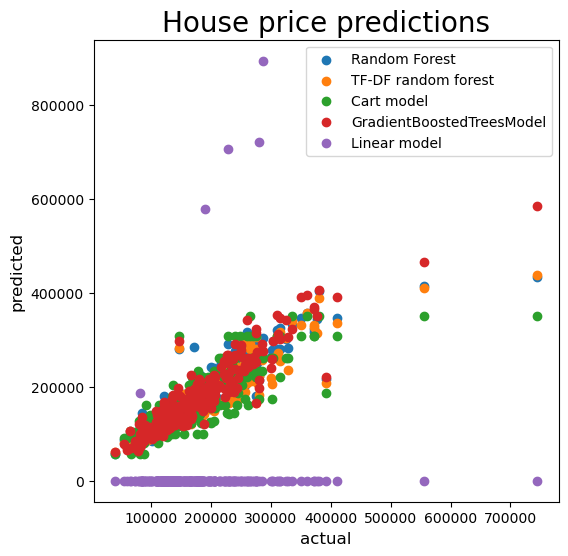

In [112]:
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title('House price predictions',fontsize=20)
    ax.set_ylabel('predicted',fontsize=12)
    ax.set_xlabel('actual',fontsize=12)
    ax.scatter(np.exp(y_test), predictions_regressor,label='Random Forest')
    ax.scatter(np.exp(y_test), predictions_rf,label='TF-DF random forest')
    ax.scatter(np.exp(y_test), predictions_cm,label='Cart model')
    ax.scatter(np.exp(y_test), predictions_gb,label='GradientBoostedTreesModel')
    ax.scatter(np.exp(y_test), predictions_lm,label='Linear model')
    ax.legend()


In [87]:
# Map model names to their corresponding classes
models = {
    "gradient_boosted_trees": tfdf.keras.GradientBoostedTreesModel,
    "random_forest": tfdf.keras.RandomForestModel
}

# Define model hyperparameter configurations
params = {
    "gradient_boosted_trees": {
        "num_trees": [50, 100, 200, 500, 1000],
        "shrinkage": [0.01, 0.05, 0.1, 0.3, 0.5],
        "max_depth": [3, 4, 5, 6, 8, 10],
        "min_examples": [2, 5, 10, 15]
    },
    "random_forest": {
        "num_trees": [100, 200, 500],
        "max_depth": [-1, 10, 30],
        "min_examples": [2, 5, 10]
    }
}

num_trials = {
    "gradient_boosted_trees": 10,
    "random_forest": 20
}

# Placeholder to store model output
output_logs = []

In [88]:
# Train each model
for model_name, config in params.items():
    output_logs.append(f"Training and tuning {model_name}...")

    num_trial = num_trials.get(model_name, 10)  # Get the number of trials for the model
    tuner = tfdf.tuner.RandomSearch(num_trials=num_trial)
    
    # Loop through the configuration dictionary and set the hyperparameters
    for param, values in config.items():
        tuner.choice(param, values)
    
    model_class = models[model_name]  # Get the corresponding model class
    model = model_class(task=tfdf.keras.Task.REGRESSION, tuner=tuner)
    
    model.fit(train_ds)

    #get best parameters
    tuning_logs = model.make_inspector().tuning_logs()
    best_params = tuning_logs[tuning_logs.best].iloc[0]
    
    predictions_log = model.predict(test_ds)
    y_pred = np.exp(predictions_log)
    y_true = np.exp(y_test)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    output_logs.append(f"Best parameters for {model_name}: {best_params}")
    output_logs.append(f"Best RMSE for {model_name}: {rmse:.6f}")

Use /var/folders/dw/bq4phr0s4yz1_3vy2_gppjcm0000gp/T/tmpr4zjriby as temporary training directory
Reading training dataset...


[WARNING 25-01-15 14:08:34.9304 EST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 25-01-15 14:08:34.9304 EST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 25-01-15 14:08:34.9304 EST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.328653. Found 1165 examples.
Training model...
Model trained in 0:00:09.754847
Compiling model...


[INFO 25-01-15 14:08:45.0182 EST kernel.cc:1233] Loading model from path /var/folders/dw/bq4phr0s4yz1_3vy2_gppjcm0000gp/T/tmpr4zjriby/model/ with prefix 6dd44884c81a43d3
[INFO 25-01-15 14:08:45.0191 EST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 25-01-15 14:08:45.0191 EST kernel.cc:1061] Use fast generic engine


Model compiled.


1/1 [==============================] - 0s 72ms/step
Use /var/folders/dw/bq4phr0s4yz1_3vy2_gppjcm0000gp/T/tmpkt7aq3lh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.297603. Found 1165 examples.
Training model...


[INFO 25-01-15 14:09:24.1456 EST kernel.cc:1233] Loading model from path /var/folders/dw/bq4phr0s4yz1_3vy2_gppjcm0000gp/T/tmpkt7aq3lh/model/ with prefix cb7a7e03941141f1


Model trained in 0:00:38.553663
Compiling model...


[INFO 25-01-15 14:09:24.4099 EST decision_forest.cc:734] Model loaded with 500 root(s), 218842 node(s), and 80 input feature(s).
[INFO 25-01-15 14:09:24.4100 EST abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 25-01-15 14:09:24.4100 EST kernel.cc:1061] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 88ms/step


In [89]:
for log in output_logs:
    print(log)

Training and tuning gradient_boosted_trees...
Best parameters for gradient_boosted_trees: score             -0.159583
evaluation_time    1.070461
best                   True
num_trees                50
shrinkage               0.3
max_depth                 4
min_examples              2
Name: 3, dtype: object
Best RMSE for gradient_boosted_trees: 28356.909593
Training and tuning random_forest...
Best parameters for random_forest: score              -0.152176
evaluation_time    30.739577
best                    True
num_trees                500
max_depth                 10
min_examples               2
Name: 17, dtype: object
Best RMSE for random_forest: 34789.153809


In [ ]:
#gradient boosting has the lowest RMSE. That will be used for the final model. 

In [125]:
#merge train_ds and test_ds
total_ds=pd.concat([train,test])

In [118]:
total_ds = tfdf.keras.pd_dataframe_to_tf_dataset(total_ds, label="SalePrice", task = tfdf.keras.Task.REGRESSION)


In [119]:
# Create a RandomSearch tuner
tuner_gb = tfdf.tuner.RandomSearch(num_trials=10)

tuner_gb.choice("num_trees", [50, 100, 200, 500, 1000])
tuner_gb.choice("shrinkage", [0.01, 0.05, 0.1, 0.3, 0.5])
tuner_gb.choice("max_depth", [3, 4, 5, 6, 8, 10])
tuner_gb.choice("min_examples", [2, 5, 10, 15])

In [120]:
# Initialize and train Gradient Boosted Trees Regression model
model_gb_regressor = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.keras.Task.REGRESSION,
    tuner=tuner_gb
)

model_gb_regressor.fit(total_ds)
print("Model training complete.")

Use /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmpbw1o1ugy as temporary training directory
Reading training dataset...


[WARNING 25-01-23 08:51:37.2455 GMT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 25-01-23 08:51:37.2469 GMT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 25-01-23 08:51:37.2469 GMT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.552715. Found 1457 examples.
Training model...
Model trained in 0:00:12.745229
Compiling model...


[INFO 25-01-23 08:51:51.5763 GMT kernel.cc:1233] Loading model from path /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmpbw1o1ugy/model/ with prefix aefa449eda474e05
[INFO 25-01-23 08:51:51.6014 GMT quick_scorer_extended.cc:911] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 25-01-23 08:51:51.6036 GMT abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 25-01-23 08:51:51.6037 GMT kernel.cc:1061] Use fast generic engine


Model compiled.


Model training complete.


In [121]:
tuning_logs_gb = model_gb_regressor.make_inspector().tuning_logs()
# Best hyper-parameters.
tuning_logs_gb[tuning_logs_gb.best].iloc[0]

score             -0.158382
evaluation_time    3.672656
best                   True
num_trees               500
shrinkage              0.05
max_depth                 4
min_examples             10
Name: 5, dtype: object

In [157]:
#load testing data set 
testing = pd.read_csv('../data/raw/test.csv')

In [159]:
#replace LotFrontage with median of that column
median=testing['LotFrontage'].median()
testing['LotFrontage']=testing['LotFrontage'].fillna(median).astype(int)


In [166]:
median=testing['BsmtFinSF1'].median()
testing['BsmtFinSF1']=testing['BsmtFinSF1'].fillna(median).astype(int)

In [169]:
median=testing['BsmtFinSF2'].median()
testing['BsmtFinSF2']=testing['BsmtFinSF2'].fillna(median).astype(int)

In [172]:
median=testing['BsmtUnfSF'].median()
testing['BsmtUnfSF']=testing['BsmtUnfSF'].fillna(median).astype(int)

In [175]:
median=testing['TotalBsmtSF'].median()
testing['TotalBsmtSF']=testing['TotalBsmtSF'].fillna(median).astype(int)

In [178]:
median=testing['BsmtFullBath'].median()
testing['BsmtFullBath']=testing['BsmtFullBath'].fillna(median).astype(int)

In [181]:
median=testing['BsmtHalfBath'].median()
testing['BsmtHalfBath']=testing['BsmtHalfBath'].fillna(median).astype(int)

In [186]:
median=testing['GarageCars'].median()
testing['GarageCars']=testing['GarageCars'].fillna(median).astype(int)

In [189]:
median=testing['GarageArea'].median()
testing['GarageArea']=testing['GarageArea'].fillna(median).astype(int)

In [190]:
testing = tfdf.keras.pd_dataframe_to_tf_dataset(testing, task = tfdf.keras.Task.REGRESSION)

In [191]:
# Make predictions on test dataset
predictions_gb_log = model_gb_regressor.predict(testing)

# Reverse log transformation for predictions
predictions_gb = np.exp(predictions_gb_log)


2/2 [==============================] - 1s 30ms/step


In [199]:
predictions_gb

array([[108741.664],
       [160489.95 ],
       [181832.42 ],
       ...,
       [165718.75 ],
       [118684.516],
       [194253.06 ]], dtype=float32)